## Ensemble-model for cardiovascular disease prediction


#### Problem framing/statement

Train an ensemble model using GridSearchCV for hyperparameter-tuning on [this](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset) kaggle dataset. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import preprocessing

df_raw = pd.read_csv("Data/cardio_train.csv", sep=";")
df_processed = preprocessing.pre_split(df_raw)

As an initial pre-split processing step values outside of impossible bounds for weight, height, ap_hi, ap_lo, bmi, in addition to the condition ap_lo > ap_hidropped resulting in a loss of 1429 samples. Which shouldn't have a big impact on statistical signifance.
Weight bounds 30 to 250 kg
Height bounds 130 to 220 cm
Systolic blood pressure (ap_hi) bounds 70, 250
Disastolic blood pressure (ap_lo) bounds 40, 150
Bmi bounds 12, 70

I was unable to find anything resembling a clear answer to this research question from a justified source like a medical publication. I tried searching through academic sources but could find anything good.  
These values are derived from query to perplexity.ai answer to multple chain-prompt where I ask for absurd values with proper citations. I tried looking through a lot of the original sources listed, but I just couldn't find anything concretely suitable. Perplexity at least allegedly goes through everything from CDC, WHO to other medical research papers. I hope that it is at least good enough at an estimate for extreme outliers.

The extreme bounds do at least seem intuitively plausible for adults. The cutoffs for these extreme ranges are quite gentle. I did find explicit things concerning e.g world's tallest man, dwarfs etc, but they are such insane outliers that I don't think it is particularly relevant.

If this was anything other than an educational exercise. I think that the right thing to do in these types of situations is to consult relevant accredited experts instead of trying to answer it myself. Potentially could improve my general research skills, but that is more dubious since the skill of navigating these questions could require domain-specific expertise.


/home/v/Code/ai24-ml/disease_prediction/visualization.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


rows: 68571


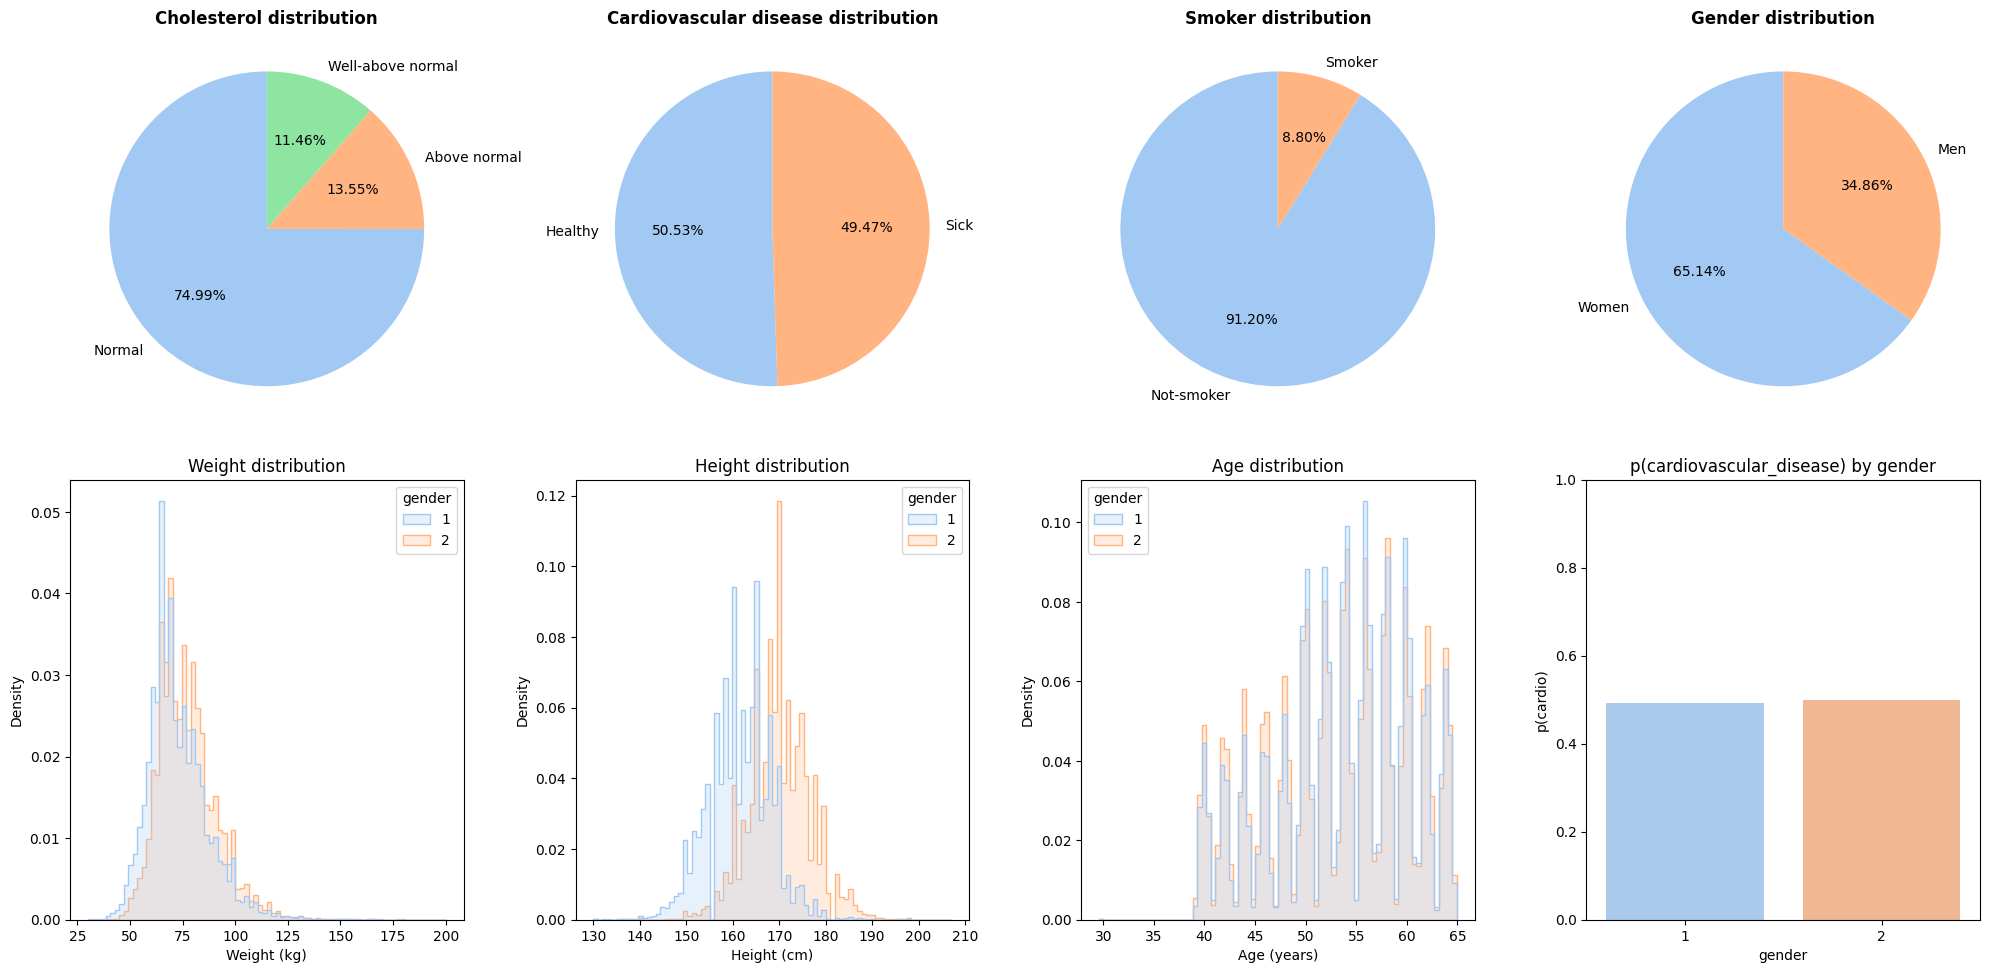

In [2]:
import visualization

visualization.eda(df_processed)

The target variable "cardio" as shown in the 2nd chart shows a balanced distribution. This means that model accuracy as a metric is less misleading. A biased distribution for the target variable could bias the model towards the majority class, at least for many standard algorithms.
Indicates that the dataset has already been rebalanced or pruned, since this is unlikely to be the true prior distirbution. No weighting or other reblanacing method necessary.

The smoking distribution chart shows an imbalanced distribution with 8.8% reported as smokers. While feature imbalance doesn't typically require dataset-level resampling or weighting techniques, it's important to note that if one category is really small, this entails analysis and model learning conditioned on that 'smoker' category are based on a smaller sample size, making them less statistically significant. Even at 8.8% having ~6000 samples is still sufficient for many machine learning models to learn the patterns associated with smoking. These conclusions generalize to the other less imbalanced features such as gender or cholesterol.

The age distribution chart shows that there are only adults (30 to 65) in this dataset. This could be helpful later when deciding what values are impossible or outliers.

The height and weight distributions seem roughly to be normally distributed. They seem strangely similar even conditioned on gender, based on this they will be treated the same when condiering outliers or impossible values later (due to time-constraints) as they will entail practically similar results. The fact that it is normally distributed makes percentile cutoff methods more intuitively applicable. Also note that for weight it is normally distributed but the fact that the graph goes to 200 shows that there are quite a few outliers. Note that after the pre-split cleaning the height graph showed more differentiation conditional on gender, which is probably a good indication that it is more accurate.

The p(cardio) by gender charts shows that the conditional on gender doesn't alter the base p(cardio) i.e independent. Doesn't mean that the feature can be removed since only a univariate analysis. To clarify it could still hold predictive power in combinatino with other features.



In [3]:
df_num = df_processed 
df_cat = df_num.copy()

X_num_train, y_num_train, X_num_val, y_num_val, X_num_test, y_num_test = preprocessing.tvt_split(df_num, "cardio", 42)
X_cat_train, y_cat_train, X_cat_val, y_cat_val, X_cat_test, y_cat_test = preprocessing.tvt_split(df_cat, "cardio", 42)

In [4]:
X_num_train, X_num_val, X_num_test = preprocessing.winsorize(X_num_train, X_num_val, X_num_test)
X_cat_train, X_cat_val, X_cat_test = preprocessing.post_split_cat(X_cat_train, X_cat_val, X_cat_test)

#### Post-split processing

Winzorizing (capping) weight, height, bmi, and blood pressure (ap_hi, ap_lo) at the lower end of 1% and a higher end of 99% percentiles. This range was chosen based on inspections of different percentile values for each feature in the dataset and it was intuitively determined to be a good cutoff point. It is a relatively modest cutoff that still gets rid of the most extreme values. For similar reasons as prior when mentioning the most extreme absurd values, truly rigorous empirical cutoffs could not be determined.

I elected to winsorize rather than drop in order to preserve more of the original samples in the dataset. Just because one value is an outlier doesn't mean that the entire row has to be dropped. When you cap values in a reasonable range it mitigates the impact of extreme values which can heavily bias certain machine-learning models.

This is done post-plit on the training set only to avoid data leakage, since it selects them based on aggregate percentile value.


The blood pressure categories are based on https://www.healthline.com/health/high-blood-pressure-hypertension#readings  
The bmi categories are based on https://en.wikipedia.org/wiki/Body_mass_index#Categories

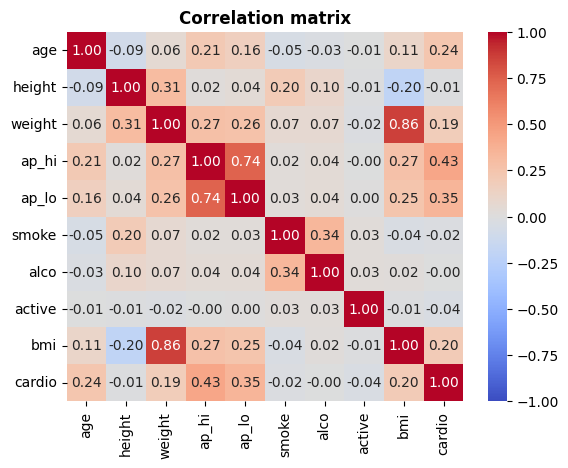

In [5]:
fig, ax = plt.subplots(1,1)
visualization.correlation_heatmap(X_num_train, y_num_train, ax)


#### Correlation matrix analysis

The goal of the correlation matrix data analysis is to get an understanding of the linear relationships. Which means only the numerical are relevant, but the ones that are binary are also alright to include. Gender was omitted since it has 1, 2 labelling so won't work well.

The correlation matrix was done post-split on the training set to avoid data leakage. This is done since it is comparing things to the target variable, which could influence the decisions the researcher makes in how to engineer the training setup, this could lead to a model that doesn't generalize well.

There are correlations between features. Bmi is obviously correlated with the features it is derived from. There is a strong correlation of 0.74 between the systolic (ap_hi) and diastolic (ap_lo) blood pressures. There is also a somehwat weak correlation of 0.31 between weight and height. There are also somewhat weak correlation of 0.27 between systolic blood pressure (ap_hi) and bmi, weight. These findings suggest to not use them together for the datasets used to train the model(s). This is exactly what will be done in terms of feature engineering and splitting the datasets. A bmi feature will be used instead of the correlated weight and height. Blood pressures will be combined into categorical value based on both. etc. It also means I lean towards using the categorical dataset.

The target ("cardio") somewhat weakly correlates 0.24 with age, moderately 0.43, 0.35 with systolic and diastolic blood pressures, and it correlates somehwat weakly 0.20 with bmi

/home/v/Code/ai24-ml/disease_prediction/visualization.py:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportion_df = df.groupby(feature)["cardio"].mean().reset_index()
/home/v/Code/ai24-ml/disease_prediction/visualization.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


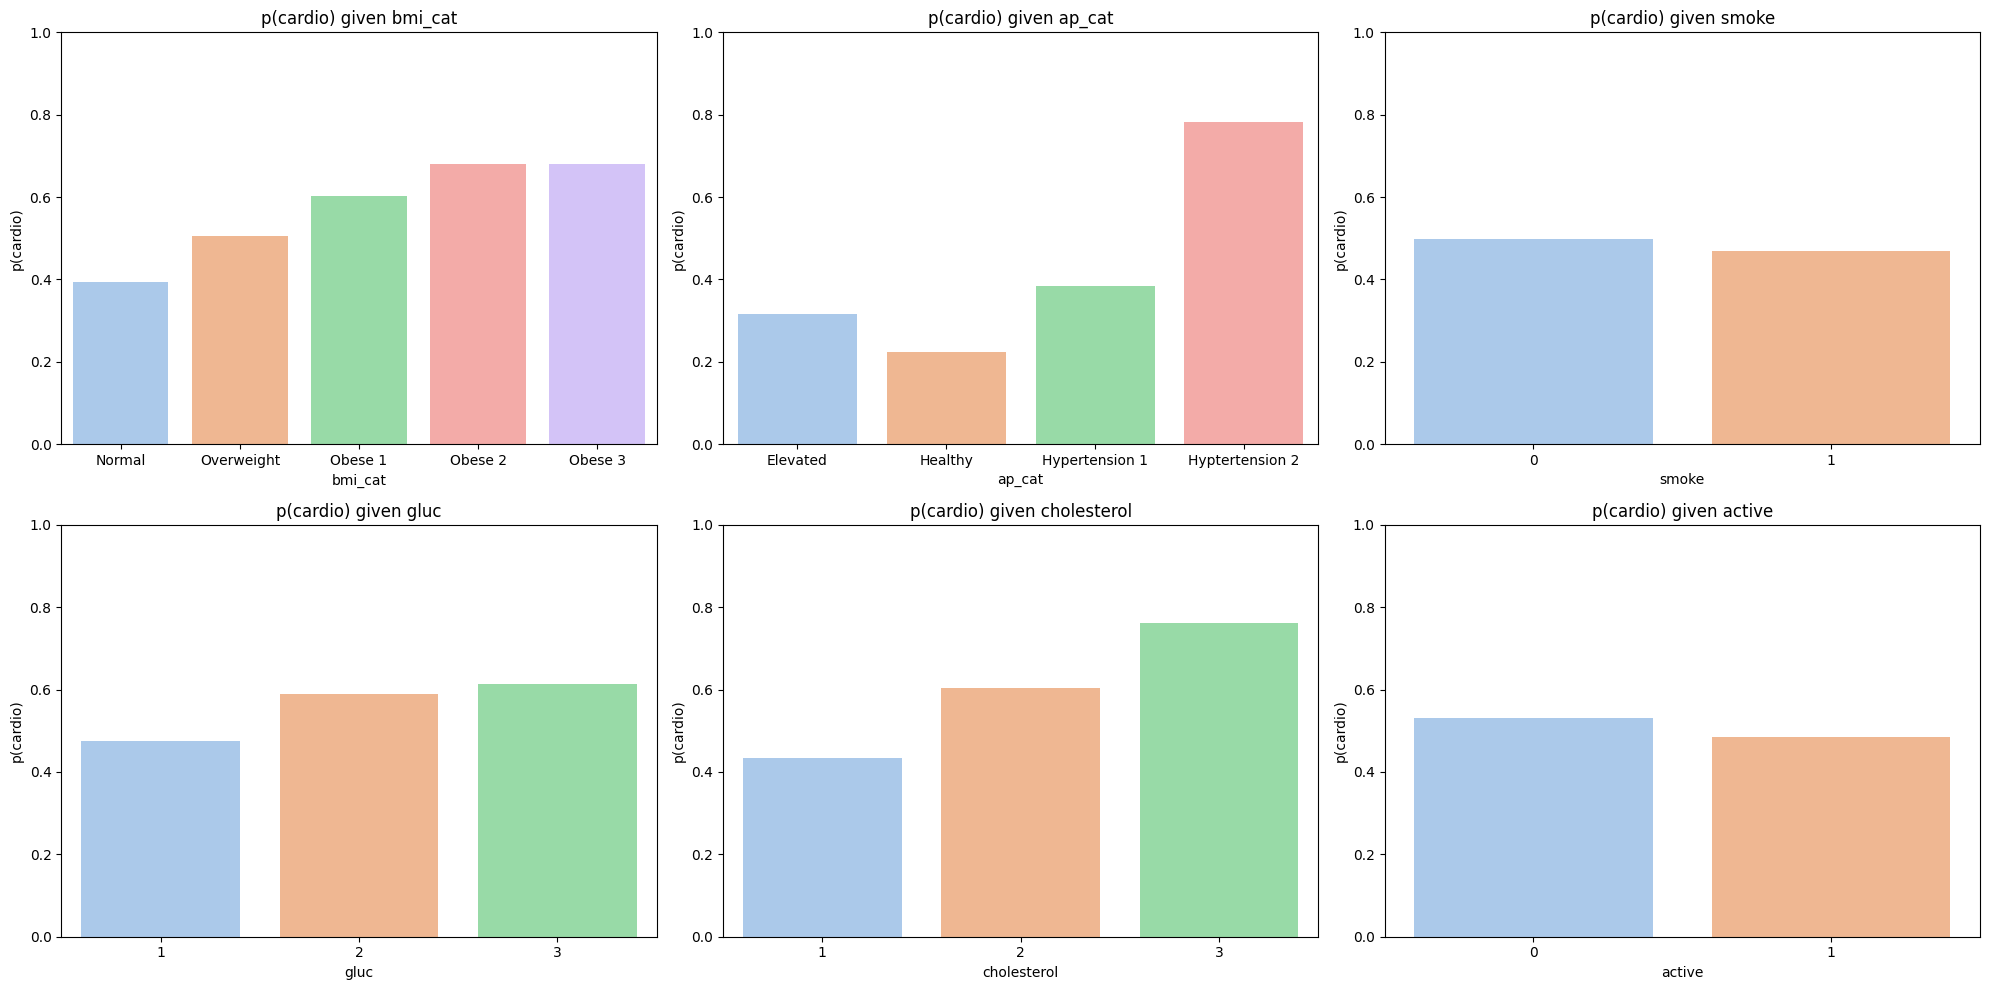

In [6]:
visualization.cardio_conditional_features(X_cat_train, y_cat_train)

#### Relationship between categorical features and cardiovascular disease

Aim of this analysis is similar to correlation matrix but for categorical features. It shows how the features relate to p(cardio) conditional on each category value. Potentially it comfirms/disconfirms things I have already learned in correlation matrix of what should be relevant, as well as show some new features that was not suitable for the matrix.

Analysis done post-split since it considers target variable, as well as wanting to do the category feature engineering after winsorizing the data so as to avoid miscategorizing.

As expected from the analysis done previously in the correlation matrix:  
  The categorical version of bmi significantly affects "cardio". The relation seems pretty linear up to obesity 2 and then it remains the same for obesity 3, suggesting a threshold effect. 
  Similarily, we can also see that ap_cat or blood pressure categories significantly affect "cardio". It doesn't seem to be a "linear" relationship though, since it seems primarily like Hypertension 2 being the threshold for which it strongly affects the target variable.

As for previously uninvestigated features:  
  Glucose (gluc) seems to have a weak positive reltionship with target, but potentially not big enough to be significant.
  Cholesterol level seems to have a strong positive relationship with "cardio" almost as strong as hypertension 2, but a bit more gradual/incremental.

As expected from prevoius correlation matrix analysis, smoking (smoke) and activity level (active) seem to be independent to the target. Surprisingly it would seem from the data to be a little bit better to be an inactive, smoker suggesting that these are probably just random fluctuations in the data. Also note that these are self-reported and potentially people lie during examinations.

Takeaways: Mostly just confirms expecations. The fact that there is a threshold effect and that after that threshold ap_cat has a particularly strong relationship suggests further that the dataframe with categories is favored. In addition is shows probably that a basic linear model would not capture the relationship well. It also shows that cholesterol and to some minor extent are important.


In [7]:
X_cat_train, X_cat_val, X_cat_test = preprocessing.pre_train_cat(X_cat_train, X_cat_val, X_cat_test)
X_num_train, X_num_val, X_num_test = preprocessing.pre_train_num(X_num_train, X_num_val, X_num_test)

#### Justification pre-tuning

F_beta = 3 or F-3 score as selected to be my primary metric. Determined by considering recall to be the most important metric in the context of aiding medical diagnois, however a pure recall score doesn't take into account precision which is also an important concern. The beta=3 was determined by intuitive guess, simply by imagining the relative costs and benefits of missing a case of cardiovascular disease (high cost but hard to quantify) in a patient that has it vs diagnosing them with cardio disease when they don't have it (wasting doctor time, resources).

An ensemble of models were chosen, since if you pick ones that are sufficiently different they tend to be more robust to data ditribution shifts. Basically it has a higher chance of generalizing better on test or real data.

Logistic regression, randomforest and k-nearest neighbor (KNN) were chosen. They are diverse, representing different families of algorithms. Which if they get a high score, will provide a robust ensemble that generalises well. And if they were to prove unsuccessful or differ, then it could inform my next better selection of models for the ensemble. Also they are quite computationally cheap.

How did I select the Hyperparameter for tuning GridSearchCV process?  
The most important concept when considering hyperparameter tuning is trying to find the sweet spot between overfitting and underfitting. With that in mind C, Penalty were the obvious candidates that I picked. For random forest similarly I focused on max_depth as the parameter adding complexity, and min_samples_leaf as the main term to simplify / prevent overfit. For KNN I judged only the n-neighbor term to be significant, as it handles the complexity tradeoff.  
Some other noteworthy parameters?
n_estimators is a key parameter for random forest. 
For logistic regression I decided to specifically include both l1 and l2 regularization which limited my choice of solvers, but I still had the option of saga vs liblinear.



#### The tuning and final selection
about the tuning process itself how final model and dataset picked?

messing around with different ranges of values a few at a time and only for the categorical set at first. Also ran them together just to compare which one were best hyperparameters for each and such. Noticed that the numerical dataset consistently better, even though more compute-expensive.

Ended up focusing more on the numerical dataset only. Trying a bunch of stuff and ranges.
some things always selected higher, but stopped really doing anything like n_estimators. I didn't stress test these too much, but I did try to at least find a reasonable max value. For log reg liblinear was always chosen so I removed saga from the options.
I tried to as mentioned before find the sweet spot between overfitting and underfitting for the models individually. Which means I always kept considering the delta between train-set and valuation-set, and taking that into account when trying to turn the "knobs".

Ended up picking the numerical dataset with the full 3-model ensemble for the final selection. I just upgraded cv variable to 5 and used those best parameters to run my final ensemble model.

In [8]:
import modeling

#val_catset_eval = modeling.tuning(X_cat_train, y_cat_train, X_cat_val, y_cat_val, "categorical")
print()
val_numset_eval = modeling.tuning(X_num_train, y_num_train, X_num_val, y_num_val, "numerical")



Starting hyperparameter tuning for numerical dataset
tuning Logistic regression
gridsearch fit for Logistic regression completed 95.51 seconds
Evaluating best Logistic regression on val data
All models tuned and evaluated on validation set
tuning Random forest
gridsearch fit for Random forest completed 126.33 seconds
Evaluating best Random forest on val data
All models tuned and evaluated on validation set
tuning KNN
gridsearch fit for KNN completed 109.38 seconds
Evaluating best KNN on val data
All models tuned and evaluated on validation set


In [9]:
pd.set_option('display.max_colwidth', None)
#modeling.tuning_score_summary(val_catset_eval, dataset_name="Categorical")
print()
modeling.tuning_score_summary(val_numset_eval, "Numerical")


--Numerical dataset score summary--
Mean f3-score: 0.6800
Mean f3-score-train: 0.7055
                 Model  F3-Score  F3-Score-Train  Recall score (sick)  \
0  Logistic regression  0.669183        0.677129             0.661820   
1        Random forest  0.688014        0.713827             0.681863   
2                  KNN  0.682676        0.725532             0.678719   

   Precision score (sick)  \
0                0.743652   
1                0.748813   
2                0.720484   

                                                  Best parameters  
0             {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}  
1  {'max_depth': 15, 'min_samples_leaf': 20, 'n_estimators': 200}  
2                                             {'n_neighbors': 15}  


In [10]:
model_ensemble, test_set_eval = modeling.ensemble(
    X_num_train, y_num_train, X_num_val, y_num_val,
    X_num_test, y_num_test, val_numset_eval)


Training VotingClassifier...
VotingClassifier training complete. Took 11.517220973968506 seconds


--Final ensemble model scores--

F3-score: 0.7017

Classifiction Report
              precision    recall  f1-score   support

     Healthy       0.72      0.77      0.74      5198
        Sick       0.75      0.70      0.72      5088

    accuracy                           0.73     10286
   macro avg       0.73      0.73      0.73     10286
weighted avg       0.73      0.73      0.73     10286




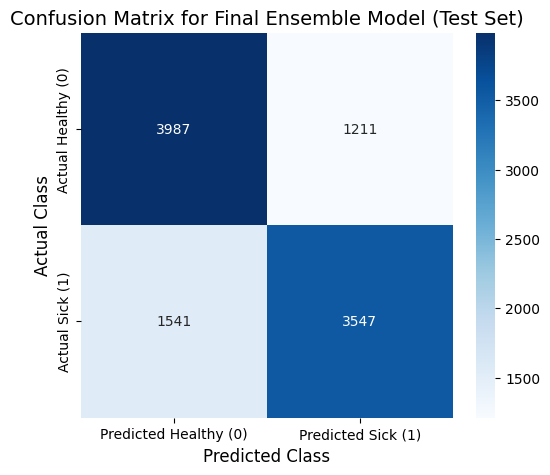

In [ ]:
modeling.final_result(test_set_eval)